In [ ]:
import numpy as np
import pandas as pd

file_paths = [
    "Måling/PlutoK.csv",
    "Måling/PlutoM.csv"]

RBW = 100 # Hz
VBW = 1000 # Hz

columns = ['Power [dBW]', 'Frequency[Hz]']
spektrum = {}
keys = ['PlutoK', 'PlutoM']
spektrum = {key: pd.DataFrame() for key in keys}
for file_path, key in zip(file_paths, keys):
    spektrum[key] = pd.read_csv(file_path, sep=',', names=columns, skiprows=154)
    spektrum[key]['Frequency[GHz]'] = spektrum[key]['Frequency[Hz]'] / 1e9
    spektrum[key]['Power [dBW]'] = spektrum[key]['Power [dBW]'] + 30 # Attenuator + 30 dB


Threshold [dB] PlutoK [kHz]   PlutoM [kHz]   
-6             81.88          85.21          
-10            93.96          95.62          
-15            104.79         105.62         
-20            111.04         111.46         


PlutoK peak offset: 32.29 kHz
PlutoM peak offset: 24.79 kHz


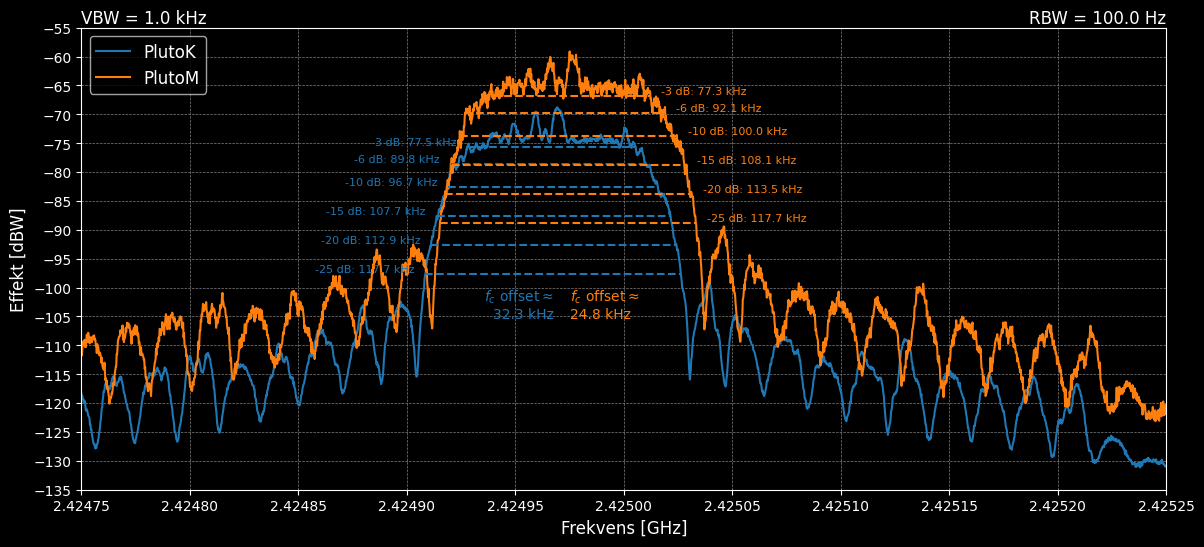

In [135]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')


colors = ['tab:blue', 'tab:orange']
plt.figure(figsize=(14, 6))
for key, color in zip(keys, colors):
    plt.plot(spektrum[key]['Frequency[GHz]'], spektrum[key]['Power [dBW]'], linestyle='-', color=color, label=key)

bw_thresholds = [3, 6, 10, 15, 20, 25]
for threshold in bw_thresholds:
    for key, color in zip(keys, colors):
        max_power = spektrum[key]['Power [dBW]'].rolling(window=150, center=True).mean().max() # Fjerner støy + peaks
        threshold_power = max_power - threshold
        # Find the frequency range where the power is above the threshold
        mask = spektrum[key]['Power [dBW]'] >= threshold_power
        freq_range = spektrum[key][mask]['Frequency[Hz]']
        bw = freq_range.max() - freq_range.min()

        if not freq_range.empty:
            plt.plot(freq_range / 1e9, [threshold_power] * len(freq_range), linestyle='--', color=color, alpha=1)
            if key == keys[0]:
                plt.annotate(f'{-threshold} dB: {bw/1e3:.1f} kHz', xy=(freq_range.iloc[0] / 1e9 - 0.000005, threshold_power), color=color, fontsize=8, ha='right', va='bottom')
            elif key == keys[1]:
                plt.annotate(f'{-threshold} dB: {bw/1e3:.1f} kHz', xy=(freq_range.iloc[-1] / 1e9 + 0.000005, threshold_power), color=color, fontsize=8, ha='left', va='bottom')

# Frekvens offset fra forventet LO-frekvens
for key, color in zip(keys,colors):
    # Calculate the mean power and frequency for each key
    f_max_index = spektrum[key]['Frequency[Hz]'][spektrum[key]['Power [dBW]'].rolling(window=400, center=True).mean() == spektrum[key]['Power [dBW]'].rolling(window=400, center=True).mean().max()].index[0]
    f_max = spektrum[key]['Frequency[Hz]'][f_max_index]
    f_c=2.425e9 # center frequency    
    peak_offset = np.abs(f_max - f_c)/1e3
    print(f'{key} peak offset: {peak_offset:.2f} kHz')
    if key == keys[0]:
        plt.annotate(r'$f_c$ offset$\approx$'+f'\n{peak_offset:.1f} kHz', xy=(f_max/1e9, -100), color=color, fontsize=10, ha='right', va='top')
    elif key == keys[1]:
        plt.annotate(r'$f_c$ offset$\approx$'+f'\n{peak_offset:.1f} kHz', xy=(f_max/1e9, -100), color=color, fontsize=10, ha='left', va='top')
    

plt.annotate('RBW = {:.1f} Hz'.format(RBW), xy=(1, 1.01), xycoords='axes fraction', fontsize=12, ha='right')
plt.annotate('VBW = {:.1f} kHz'.format(VBW/1000), xy=(0, 1.01), xycoords='axes fraction', fontsize=12, ha='left')

plt.xticks(np.arange(2.42475, 2.42525, 0.00005))
plt.yticks(np.arange(-135, -54, 5))
plt.xlim(2.42475, 2.42525)
plt.ylim(-135, -55)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.ylabel('Effekt [dBW]', fontsize=12)
plt.xlabel('Frekvens [GHz]', fontsize=12)
plt.legend(loc='upper left', fontsize=12)
plt.savefig('Figurer/PlutoSpektrum.pdf', bbox_inches='tight')
plt.show()